In [953]:
import pdb
import pandas as pd
import numpy as np
import os
import random
from scipy import stats
from scipy.stats import gaussian_kde
from datetime import datetime, timedelta
from faker import Faker
from sklearn.neighbors import KernelDensity
np.random.seed(3101)
random_state = np.random.RandomState(3101)
fake = Faker()
pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))

# Importing data:
bank1 = archive  
bank2 = bank+marketing

In [954]:
# print(os.getcwd())
bank_df_train = pd.read_csv('./data/main/train.csv')
bank_df_test = pd.read_csv('./data/main/test.csv')

In [955]:
print(bank_df_train.head())
print(len(bank_df_train))

# bank_df_train_clean = bank_df_train.drop_duplicates(subset="CustomerId", keep="first")
# print(len(bank_df_train_clean))

   id  CustomerId         Surname  CreditScore Geography Gender       Age  \
0   0    15674932  Okwudilichukwu          668    France   Male 33.000000   
1   1    15749177   Okwudiliolisa          627    France   Male 33.000000   
2   2    15694510           Hsueh          678    France   Male 40.000000   
3   3    15741417             Kao          581    France   Male 34.000000   
4   4    15766172       Chiemenam          716     Spain   Male 33.000000   

   Tenure       Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       3      0.000000              2   1.000000        0.000000   
1       1      0.000000              2   1.000000        1.000000   
2      10      0.000000              2   1.000000        0.000000   
3       2 148882.540000              1   1.000000        1.000000   
4       5      0.000000              2   1.000000        1.000000   

   EstimatedSalary  Exited  
0    181449.970000       0  
1     49503.500000       0  
2    184866.690000       0  
3     

In [956]:
print(bank_df_test.head())
len(bank_df_test)
# duplicates = bank_df_test.duplicated(subset=['CustomerId'], keep=False)
# print(duplicates)
#no "exited" column

       id  CustomerId    Surname  CreditScore Geography  Gender       Age  \
0  165034    15773898   Lucchese          586    France  Female 23.000000   
1  165035    15782418       Nott          683    France  Female 46.000000   
2  165036    15807120         K?          656    France  Female 34.000000   
3  165037    15808905  O'Donnell          681    France    Male 36.000000   
4  165038    15607314    Higgins          752   Germany    Male 38.000000   

   Tenure       Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2      0.000000              2   0.000000        1.000000   
1       2      0.000000              1   1.000000        0.000000   
2       7      0.000000              2   1.000000        0.000000   
3       8      0.000000              1   1.000000        0.000000   
4      10 121263.620000              1   1.000000        0.000000   

   EstimatedSalary  
0    160976.750000  
1     72549.270000  
2    138882.090000  
3    113931.570000  
4    139431.00000

110023

Data Cleaning

Removed CustomerId column in both test & train since it is an unused var in the original dataset
All other columns returns no duplicates
scalling tenure too to when the bank opened

Percentage of 0 entries in 'Balance': 54.32%


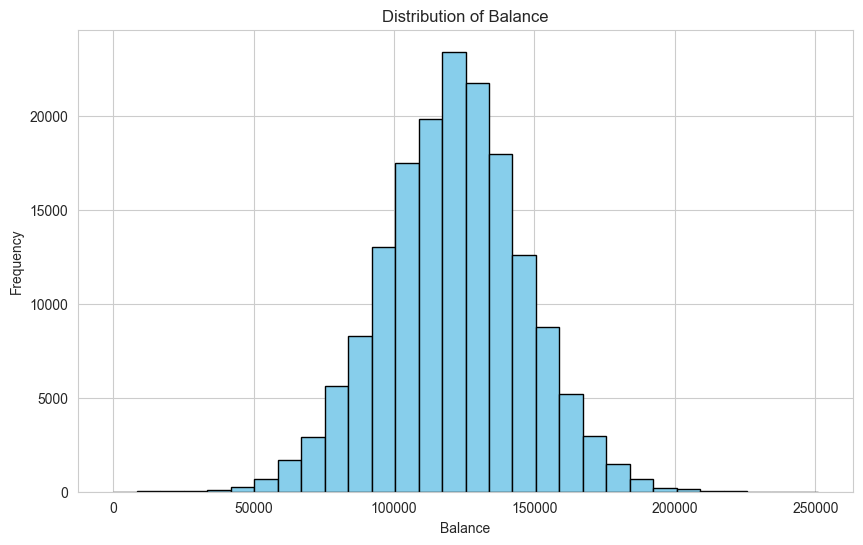

In [957]:
import matplotlib.pyplot as plt


zero_count = (bank_df_train['Balance'] == 0).sum()
total_count = len(bank_df_train)
zero_percentage = (zero_count / total_count) * 100

print(f"Percentage of 0 entries in 'Balance': {zero_percentage:.2f}%")

non_zero_data = bank_df_train.loc[bank_df_train['Balance'] != 0, 'Balance']
mean_non_zero = non_zero_data.mean()
std_non_zero = non_zero_data.std()

zero_indices = bank_df_train.index[bank_df_train['Balance'] == 0]
num_zeros = len(zero_indices)
random_samples = np.random.normal(loc=mean_non_zero, scale=std_non_zero, size=num_zeros)
bank_df_train.loc[zero_indices, 'Balance'] = random_samples


plt.figure(figsize=(10, 6))
plt.hist(bank_df_train['Balance'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Distribution of Balance')
plt.grid(True)
plt.show()


# OverSampling

In [958]:
from sklearn.utils import resample
percentage_exited_1 = (bank_df_train['Exited'] == 1).mean() * 100

print(f"Percentage of Exited=1: {percentage_exited_1:.2f}%")

class_distribution = bank_df_train['Exited'].value_counts(normalize=True)

desired_percentage_exited_1 = 0.5

while class_distribution[1] < desired_percentage_exited_1:
    oversampled_minority = resample(
        bank_df_train[bank_df_train['Exited'] == 1], 
        replace=True,
        n_samples=len(bank_df_train[bank_df_train['Exited'] == 0]),  
        random_state=42
    )
    bank_df_train = pd.concat([bank_df_train, oversampled_minority])
    class_distribution = bank_df_train['Exited'].value_counts(normalize=True)

oversampled_class_distribution = bank_df_train['Exited'].value_counts(normalize=True)
print(oversampled_class_distribution)
print(len(bank_df_train))

Percentage of Exited=1: 21.16%
Exited
1   0.559159
0   0.440841
Name: proportion, dtype: float64
295147


# Customer ID

In [959]:
n_rows = len(bank_df_train)
new_customer_ids = range(1, n_rows + 1)

bank_df_train['CustomerId'] = new_customer_ids

In [960]:
# bank_df_train = bank_df_train.loc[:, bank_df_train.columns!='CustomerId'] # extract all columns except for CustomerId
# print(bank_df_train[bank_df_train.duplicated() == True]) # check for duplicate columns 

# bank_df_test = bank_df_test.loc[:, bank_df_test.columns!='CustomerId']

### DELETE OR COMMENT OUT THIS LATER ###
# bank_df_train.drop_duplicates(subset=['CustomerId'], inplace=True)
# bank_df_test.drop_duplicates(subset=['CustomerId'], inplace=True)
### DELETE OR COMMENT OUT THIS LATER ###
bank_df_train['Age'] = bank_df_train['Age'].astype(int)
bank_df_test['Age'] = bank_df_test['Age'].astype(int)

n_train = len(bank_df_train)
n_test = len(bank_df_test)


aug_2022 = datetime(2022, 8, 31)
today = datetime.now()
months_since_aug_2022 = (today.year - aug_2022.year) * 12 + today.month - aug_2022.month - 2
def scale_int_to_months(int_val):
    return int_val * (months_since_aug_2022 / 10)
bank_df_train['Tenure'] = bank_df_train['Tenure'] * (months_since_aug_2022 / 10)
bank_df_train['Tenure'] = bank_df_train['Tenure'].astype(int)

random_numbers = np.random.rand(n_train)
threshold = 0.5
print(random_numbers)
bank_df_train.loc[random_numbers > threshold, 'Tenure'] += 1

print(bank_df_train['Tenure'].head(20))

[0.63461568 0.31213008 0.56974709 ... 0.59702059 0.19984192 0.8792945 ]
0      6
1      1
2     19
3      3
4      9
5      8
6     14
7      1
8      7
9      7
10    11
11     5
12    17
13     9
14    12
15     9
16    12
17     8
18    15
19     1
Name: Tenure, dtype: int32


# Adding and populating features

### 13. Churn Date: The exact date the customer decided to exit.

In [961]:
start_date = datetime(2022, 8, 31)
end_date = end_date = datetime.now().strftime('%Y-%m-%d') 

# random_dates = pd.date_range(start=start_date, end=end_date, freq='D')
# random_dates_str = random_dates.strftime('%Y-%m-%d')
# bank_df_train['ChurnDate'] = np.where(bank_df_train['Exited'] == 1, np.random.choice(random_dates_str) , np.nan) 
def generate_random_date(exited, tenure_months):
    if exited == 1:
        tenure_days = tenure_months * 30
        random_date = np.random.choice(pd.date_range(start=start_date + timedelta(days=tenure_days), end=end_date, freq='D'))
        return random_date
    else:
        return np.nan
bank_df_train['ChurnDate'] = bank_df_train.apply(lambda row: generate_random_date(row['Exited'], row['Tenure']), axis=1)

# random_dates = pd.date_range(start=start_date, end=end_date, freq='D')
# random_dates_str = random_dates.strftime('%Y-%m-%d')
# bank_df_train['ChurnDate'] = np.where(bank_df_train['Exited'] == 1, np.random.choice(random_dates_str) , np.nan) 
# bank_df_train['ChurnDate'] = pd.to_datetime(bank_df_train['ChurnDate'])
print(bank_df_train[['Tenure', 'ChurnDate']].head(30))

    Tenure  ChurnDate
0        6        NaT
1        1        NaT
2       19        NaT
3        3        NaT
4        9        NaT
5        8 2023-06-17
6       14        NaT
7        1        NaT
8        7        NaT
9        7        NaT
10      11        NaT
11       5        NaT
12      17        NaT
13       9        NaT
14      12        NaT
15       9        NaT
16      12        NaT
17       8        NaT
18      15 2024-01-19
19       1 2023-09-06
20      16        NaT
21      15        NaT
22      16        NaT
23      17 2024-03-14
24      10        NaT
25      16 2024-01-26
26       5        NaT
27       3        NaT
28       7 2024-01-14
29      10        NaT


### months inactive


In [962]:
np.random.seed(3101)
bank_df_train['MonthsInactive'] = np.minimum(np.random.normal(0.5, 1.5, n_train), bank_df_train['Tenure'] * 12)
bank_df_train['MonthsInactive'] = np.maximum(bank_df_train['MonthsInactive'], 0)

bank_df_test['MonthsInactive'] = bank_df_test.apply(lambda row: 
    np.random.normal(0.5, 1.5) if row['IsActiveMember'] == 0 else 0,
    axis=1)


def set_max_to_tenure(row):
    return min(row['MonthsInactive'], row['Tenure'])

bank_df_train['MonthsInactive'] = np.maximum(bank_df_train['MonthsInactive'], 0)
bank_df_train['MonthsInactive'] = bank_df_train.apply(set_max_to_tenure, axis=1)
bank_df_train['MonthsInactive'] = bank_df_train['MonthsInactive'].astype(int)
bank_df_test['MonthsInactive'] = np.maximum(bank_df_test['MonthsInactive'], 0)
bank_df_test['MonthsInactive'] = bank_df_test.apply(set_max_to_tenure, axis=1)
bank_df_test['MonthsInactive'] = bank_df_test['MonthsInactive'].astype(int)

bank_df_train['ChurnDate'] = pd.to_datetime(bank_df_train['ChurnDate'])
current_date = pd.Timestamp.today()
bank_df_train['MonthsInactive'] = (current_date - bank_df_train['ChurnDate']) // pd.Timedelta(days=30)


# print(bank_df_train['MonthsInactive'].head(20))
print(bank_df_test['MonthsInactive'].head(20))

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     2
9     0
10    0
11    2
12    0
13    0
14    0
15    0
16    0
17    0
18    1
19    0
Name: MonthsInactive, dtype: int32


### 15.Transaction History Freq
Detailed transaction data offers insights into spending patterns and engagement. (Transaction frequency in the last 28 days)

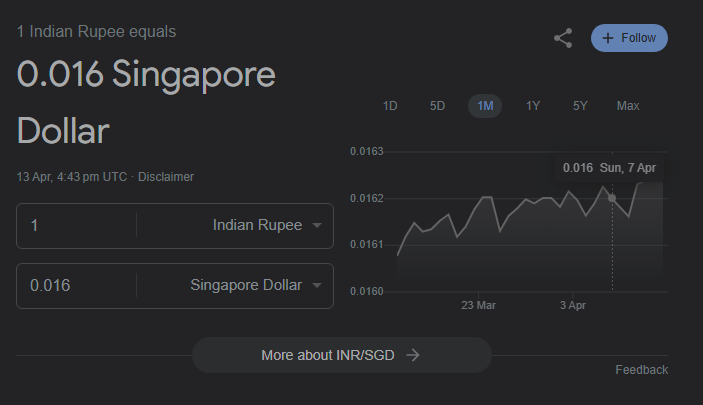


inr to sgd is * 0.016

In [963]:
# transaction_df = pd.read_excel('./data/transaction_history.xlsx')

# # print(transaction_df.head())
# transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'])

# grouped_df = transaction_df.groupby('Account No')

# results = []
# for group_name, group_data in grouped_df:
#     # Get max and min dates for the group
#     max_date = group_data['DATE'].max()
#     min_date = max_date - pd.Timedelta(days=28)
    
#     # Filter group data for transactions within the date range
#     filtered_group = group_data[(group_data['DATE'] >= min_date) & (group_data['DATE'] <= max_date)]
    
#     # Calculate transaction frequency and amount for the group
#     transaction_frequency = len(filtered_group)
#     transaction_amount = filtered_group['DEPOSIT AMT'].sum()
    
#     # Append results to the list
#     results.append({
#         'Account No': group_name,
#         'Total Transaction Amount': transaction_amount,
#         'Transaction Frequency': transaction_frequency
#     })

# # Create DataFrame from results
# result_df = pd.DataFrame(results)

# result_df['Total Transaction Amount'] = result_df['Total Transaction Amount'].astype(int)
# pd.options.display.float_format = '{:,.0f}'.format
# # print(result_df['Total Transaction Amount'])

# # print("Minimum date in the dataset:", min_date)
# # print("Maximum date in the dataset:", max_date)

# kde_freq = gaussian_kde(result_df['Transaction Frequency'])
# kde_amnt = gaussian_kde(result_df['Total Transaction Amount'])
# # print(result_df['Total Transaction Amount'])

# fake_data_freq = kde_freq.resample(len(bank_df_train)).flatten()
# fake_data_freq = np.round(fake_data_freq).astype(int)
# bank_df_train['TransactionFreq'] = fake_data_freq
# fake_data_freq = kde_freq.resample(len(bank_df_test)).flatten()
# fake_data_freq = np.round(fake_data_freq).astype(int)
# bank_df_test['TransactionFreq'] = fake_data_freq

# # fake_data_amt = kde_amnt.resample(len(bank_df_train)).flatten()
# # # fake_data_amt = np.round(fake_data_amt).astype(int)
# # bank_df_train['TransactionAmnt'] = fake_data_amt
# # fake_data_amt = kde_amnt.resample(len(bank_df_test)).flatten()
# # # fake_data_amt = np.round(fake_data_amt).astype(int)
# # bank_df_test['TransactionAmnt'] = fake_data_amt

# # print(bank_df_train['TransactionAmnt'].head())
# date_28_days_ago = datetime.now() - timedelta(days=28)

# bank_df_train['TransactionFreq'] = np.where(
#     (bank_df_train['ChurnDate'] <= date_28_days_ago),
#     0,
#     bank_df_train['TransactionFreq']
# )

# bank_df_test['TransactionFreq'] = np.where(
#     (bank_df_test['IsActiveMember'] == 0),
#     0,
#     bank_df_test['TransactionFreq']
# )

# bank_df_train['TransactionFreq'] = np.maximum(bank_df_train['TransactionFreq'], 0)
# bank_df_test['TransactionFreq'] = np.maximum(bank_df_test['TransactionFreq'], 0)

# min_train_value = bank_df_train['TransactionFreq'].min()
# max_train_value = bank_df_train['TransactionFreq'].max()
# min_test_value = bank_df_test['TransactionFreq'].min()
# max_test_value = bank_df_test['TransactionFreq'].max()

# def scale_transaction_freq_train(freq):
#     scaled_freq = ((freq - min_train_value) / (max_train_value - min_train_value)) * 150
#     return scaled_freq

# def scale_transaction_freq_test(freq):
#     scaled_freq = ((freq - min_test_value) / (max_test_value - min_test_value)) * 150
#     return scaled_freq

# bank_df_train['TransactionFreq'] = bank_df_train['TransactionFreq'].apply(scale_transaction_freq_train).astype(int)

# bank_df_test['TransactionFreq'] = bank_df_test['TransactionFreq'].apply(scale_transaction_freq_test).astype(int)

# print(bank_df_train[['ChurnDate', 'TransactionFreq']].head(20))

In [964]:
from sklearn.neighbors import KernelDensity

trans_df = pd.read_csv('./data/Daily Household Transactions.csv')

trans_df['Date'] = pd.to_datetime(trans_df['Date'], errors='coerce')

trans_df = trans_df.dropna(subset=['Date'])

trans_df['Date'] = trans_df['Date'].dt.strftime('%Y-%m-%d')

trans_df['Year'] = trans_df['Date'].str[:4].astype(int)
trans_df['Month'] = trans_df['Date'].str[5:7].astype(int)
trans_df['Day'] = trans_df['Date'].str[8:10].astype(int)
# print(trans_df['Date'].head(20))

exchange_rate_inr_to_sgd = 0.016
trans_df['Amount'] = trans_df['Amount'] * exchange_rate_inr_to_sgd
trans_df['Amount'] = trans_df['Amount'].round(2)


monthly_data = trans_df.groupby(['Year', 'Month']).agg({'Amount': 'sum', 'Date': 'count'}).reset_index()
monthly_data.rename(columns={'Amount': 'TotalAmount', 'Date': 'Frequency'}, inplace=True)
# print(trans_df.head())


kde_freq = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde_amount = KernelDensity(bandwidth=1.0, kernel='gaussian')

# Fit KDE models to frequency and total amount data
kde_freq.fit(monthly_data['Frequency'].values.reshape(-1, 1))
kde_amount.fit(monthly_data['TotalAmount'].values.reshape(-1, 1))

# Generate new samples using KDE based on the number of rows in bank_df_train
new_freq_samples = kde_freq.sample(len(bank_df_train)).reshape(-1)
new_amount_samples = kde_amount.sample(len(bank_df_train)).reshape(-1)

new_freq_samples_2 = kde_freq.sample(len(bank_df_test)).reshape(-1)
new_amount_samples_2 = kde_amount.sample(len(bank_df_test)).reshape(-1)

# Add generated samples to the DataFrame bank_df_train
bank_df_train['TransactionFreq'] = new_freq_samples
bank_df_train['TransactionFreq'] = bank_df_train['TransactionFreq'].astype(int)
bank_df_train['TransactionAmt'] = new_amount_samples

bank_df_test['TransactionFreq'] = new_freq_samples_2
bank_df_test['TransactionFreq'] = bank_df_test['TransactionFreq'].astype(int)
bank_df_test['TransactionAmt'] = new_amount_samples_2

bank_df_train.loc[(bank_df_train['Exited'] == 1) | (bank_df_train['MonthsInactive'] > 0), ['TransactionFreq', 'TransactionAmt']] = 0

print(bank_df_train[['TransactionFreq', 'TransactionAmt']].head(10))

   TransactionFreq  TransactionAmt
0               44     1451.211025
1                7     1197.820663
2                5     1975.873397
3               58     1159.449547
4                7     1201.936091
5                0        0.000000
6                8      981.293566
7               56     1029.603861
8                5      941.718586
9               33      254.669775


C:\Users\Ethan\AppData\Local\Temp\ipykernel_41856\2253686512.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  trans_df['Date'] = pd.to_datetime(trans_df['Date'], errors='coerce')


In [965]:
# from sklearn.neighbors import KernelDensity

# trans_df = pd.read_csv('./data/Daily Household Transactions.csv')
# trans_df['Date'] = pd.to_datetime(trans_df['Date'], errors='coerce')
# trans_df = trans_df.dropna(subset=['Date'])
# trans_df = trans_df[~((trans_df['Date'].dt.year == 2018) & (trans_df['Date'].dt.month == 9))]

# max_date = trans_df['Date'].max()
# today = pd.to_datetime('today').normalize()
# date_diff = today - max_date
# trans_df['Date'] += date_diff

# exchange_rate_inr_to_sgd = 0.016
# trans_df['Amount'] = trans_df['Amount'] * exchange_rate_inr_to_sgd
# trans_df['Amount'] = trans_df['Amount'].round(2)

# print(trans_df.head())



### 16. Transaction History Amt
Detailed transaction data offers insights into spending patterns and engagement. (Transaction amount in the last 28 days)


In [966]:
# # Import reference set
# # Warning: File size slightly big
# trans_hist_data = pd.read_excel('./data/transaction_history.xlsx')

# trans_hist_data.dtypes
# # trans_hist_data.describe()

# # Extract the most recent 2 sets of 3 months assuming the most recent data is the most accurate
# trans_1st_3mths = trans_hist_data[(trans_hist_data['DATE'] >= pd.to_datetime('2019-01')) & (trans_hist_data['DATE'] <= pd.to_datetime('2019-03'))]
# trans_2ns_3mths = trans_hist_data[(trans_hist_data['DATE'] >= pd.to_datetime('2018-10')) & (trans_hist_data['DATE'] <= pd.to_datetime('2018-12'))]

# trans_dist_data = trans_1st_3mths.groupby('Account No').agg({'VALUE DATE': 'size', 'WITHDRAWAL AMT':'sum', 'DEPOSIT AMT': 'sum'}).reset_index()
# trans_dist_data['TOTAL AMT'] = -trans_dist_data['WITHDRAWAL AMT'] + trans_dist_data['DEPOSIT AMT']

# # kde = gaussian_kde(trans_dist_data['VALUE DATE'])
# # train['Transaction Freq'] = abs(kde.resample(n_train).flatten()).astype(int)

# kde = gaussian_kde(trans_dist_data['TOTAL AMT'])
# bank_df_train['Cashflow'] = kde.resample(n_train).flatten().astype(float)
# bank_df_test['Cashflow'] = kde.resample(n_test).flatten().astype(float)

# date_28_days_ago = datetime.now() - timedelta(days=28)

# bank_df_train['Cashflow'] = np.where(
#     (bank_df_train['ChurnDate'] <= date_28_days_ago),
#     0,
#     bank_df_train['Cashflow']
# )

# bank_df_train['Cashflow'] = np.where(
#     (bank_df_train['TransactionFreq'] == 0),
#     0,
#     bank_df_train['Cashflow']
# )

# bank_df_test['Cashflow'] = np.where(
#     (bank_df_test['TransactionFreq'] == 0),
#     0,
#     bank_df_test['Cashflow']
# )

# new_min = -20000
# new_max = 20000

# current_min = bank_df_train['Cashflow'].min()
# current_max = bank_df_train['Cashflow'].max()

# # Perform Min-Max scaling
# bank_df_train['Cashflow'] = ((bank_df_train['Cashflow'] - current_min) / (current_max - current_min)) * (new_max - new_min) + new_min


# print(bank_df_train[['ChurnDate', 'TransactionFreq', 'Cashflow']].head(20))
# # print(bank_df_test[['TransactionFreq', 'TransactionAmt']].head(20))

In [967]:
#np.random.uniform(0, 1, size=bank_df_train.shape[0])

#bank_df_train.loc[bank_df_train['TransactionAmt'] > bank_df_train['Balance'], 'TransactionAmt'] = bank_df_train.loc[bank_df_train['TransactionAmt'] > bank_df_train['Balance'], 'TransactionAmt'] * unif[bank_df_train['TransactionAmt'] > bank_df_train['Balance']]
#bank_df_train['TransactionAmt'] > bank_df_train['Balance'] == True

# print(bank_df_train['TransactionAmt'].head(20))

### 17.Service Support Frequency (per mth)

In [968]:

support_freq = pd.read_csv("./data/support_frequency.csv")
kde = gaussian_kde(support_freq['no_of_cases'])
bank_df_train['ServiceSupportFrequency'] = abs(kde.resample(n_train).flatten()/12).astype(int)
bank_df_test['ServiceSupportFrequency'] = abs(kde.resample(n_test).flatten()/12).astype(int)

print(bank_df_train['ServiceSupportFrequency'])


0         4
1        23
2         7
3         3
4        28
         ..
45221     8
97560    42
51170    14
77844     7
46445    11
Name: ServiceSupportFrequency, Length: 295147, dtype: int32


### 18.Months Inactive
Indicates customer disengagement, potentially preceding churn. 

In [969]:
# np.random.seed(3101)
# bank_df_train['MonthsInactive'] = np.minimum(np.random.normal(0.5, 1.5, n_train), bank_df_train['Tenure'] * 12)
# bank_df_train['MonthsInactive'] = np.maximum(bank_df_train['MonthsInactive'], 0)

# bank_df_test['MonthsInactive'] = bank_df_test.apply(lambda row: 
#     np.random.normal(0.5, 1.5) if row['TransactionFreq'] == 0 else 0,
#     axis=1)

# def set_max_to_tenure(row):
#     return min(row['MonthsInactive'], row['Tenure'])

# bank_df_train['MonthsInactive'] = np.maximum(bank_df_train['MonthsInactive'], 0)
# bank_df_train['MonthsInactive'] = bank_df_train.apply(set_max_to_tenure, axis=1)
# bank_df_train['MonthsInactive'] = bank_df_train['MonthsInactive'].astype(int)
# bank_df_test['MonthsInactive'] = np.maximum(bank_df_test['MonthsInactive'], 0)
# bank_df_test['MonthsInactive'] = bank_df_test.apply(set_max_to_tenure, axis=1)
# bank_df_test['MonthsInactive'] = bank_df_test['MonthsInactive'].astype(int)



# # print(bank_df_train['MonthsInactive'].head(20))
# print(bank_df_test['MonthsInactive'].head(20))

### 19.Net Promoter Score (NPS)
Measure of customer satisfaction and loyalty.
Scaled from 1 to 10 


In [970]:
nps = pd.read_csv('./data/NPS.csv')

nps_data = nps.groupby('Customer Name').agg({'NPS':'mean'}).reset_index()
kde = gaussian_kde(nps_data['NPS'])
bank_df_train['NPS'] = abs(kde.resample(n_train).flatten()).astype(int)
bank_df_test['NPS'] = abs(kde.resample(n_test).flatten()).astype(int)
bank_df_train['NPS'] = np.ceil(bank_df_train['NPS']/12*10)
bank_df_test['NPS'] = np.ceil(bank_df_test['NPS']/12*10)
print(bank_df_train['NPS'].describe())

count   295147.000000
mean         5.739882
std          2.984798
min          0.000000
25%          4.000000
50%          7.000000
75%          8.000000
max         10.000000
Name: NPS, dtype: float64


### 20.Education
Education level might influence financial behavior and churn.
Shld be correlated to 5. Acct Balance


In [971]:
education_marital = pd.read_csv("./data/education_marital.csv")

education = education_marital['Education_Level'].unique()

edu, counts = np.unique(education, return_counts=True)
value_to_index = {value: i for i, value in enumerate(edu)}
numerical_data = [value_to_index[value] for value in education]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)

pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)
resampled_indices_test = np.random.choice(x_values, size=n_test, p=pmf)

resampled_values = [edu[index] for index in resampled_indices]
resampled_values_test = [edu[index] for index in resampled_indices_test]

bank_df_train['Education'] = resampled_values
bank_df_test['Education'] = resampled_values_test

def convert_phd_to_postdoc(edu_level):
    if edu_level == 'PHD':
        # Randomly choose between 'PHD' and 'Post-Doc' with equal probability
        return np.random.choice(['PHD', 'Post-Doc'])
    else:
        return edu_level  # Keep other education levels unchanged

bank_df_train['Education'].replace({'Unknown': 'PSLE'}, inplace=True)
bank_df_train['Education'].replace({'Uneducated': 'O/N'}, inplace=True)
bank_df_train['Education'].replace({'High School': 'A'}, inplace=True)
bank_df_train['Education'].replace({'College': 'Diploma'}, inplace=True)
bank_df_train['Education'].replace({'Graduate': 'Bachelors'}, inplace=True)
bank_df_train['Education'].replace({'Post-Graduate': 'Masters'}, inplace=True)
bank_df_train['Education'].replace({'Doctorate': 'PHD'}, inplace=True)

bank_df_train['Education'] = bank_df_train['Education'].apply(convert_phd_to_postdoc)

bank_df_test['Education'].replace({'Unknown': 'PSLE'}, inplace=True)
bank_df_test['Education'].replace({'Uneducated': 'O/N'}, inplace=True)
bank_df_test['Education'].replace({'High School': 'A'}, inplace=True)
bank_df_test['Education'].replace({'College': 'Diploma'}, inplace=True)
bank_df_test['Education'].replace({'Graduate': 'Bachelors'}, inplace=True)
bank_df_test['Education'].replace({'Post-Graduate': 'Masters'}, inplace=True)
bank_df_test['Education'].replace({'Doctorate': 'PHD'}, inplace=True)

bank_df_test['Education'] = bank_df_test['Education'].apply(convert_phd_to_postdoc)

print(bank_df_train['Education'].head(30))

0           O/N
1     Bachelors
2           O/N
3          PSLE
4             A
5             A
6       Masters
7       Masters
8     Bachelors
9           O/N
10         PSLE
11          O/N
12            A
13    Bachelors
14     Post-Doc
15            A
16     Post-Doc
17            A
18      Diploma
19      Masters
20     Post-Doc
21    Bachelors
22          O/N
23      Diploma
24    Bachelors
25          O/N
26      Diploma
27          PHD
28         PSLE
29          PHD
Name: Education, dtype: object


### 21.Employment Status
Indicates financial stability, affecting churn likelihood. 
Shld be correlated to 5. Acct Balance & 21. Education  

In [972]:
employment = pd.read_csv("./data/employment.csv")

employment_data = employment['job'].unique()

employment_status, counts = np.unique(employment_data, return_counts=True)
value_to_index = {value: i for i, value in enumerate(employment_status)}
numerical_data = [value_to_index[value] for value in employment_data]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)
pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)
resampled_indices_test = np.random.choice(x_values, size=n_test, p=pmf)

resampled_values = [employment_status[index] for index in resampled_indices]
resampled_values_test = [employment_status[index] for index in resampled_indices_test]

bank_df_train['EmploymentStatus'] = resampled_values
bank_df_test['EmploymentStatus'] = resampled_values_test

bank_df_train['EmploymentStatus'].replace({'admin.': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'blue-collar': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'entrepreneur': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'housemaid': 'Parttime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'management': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'retired': 'Retired'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'student': 'Student'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'services': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'self-employed': 'Self-employed'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'technician': 'Parttime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'unemployed': 'Unemployed'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'unknown': 'Parttime'}, inplace=True)

bank_df_test['EmploymentStatus'].replace({'admin.': 'Fulltime'}, inplace=True)
bank_df_test['EmploymentStatus'].replace({'blue-collar': 'Fulltime'}, inplace=True)
bank_df_test['EmploymentStatus'].replace({'entrepreneur': 'Fulltime'}, inplace=True)
bank_df_test['EmploymentStatus'].replace({'housemaid': 'Parttime'}, inplace=True)
bank_df_test['EmploymentStatus'].replace({'management': 'Fulltime'}, inplace=True)
bank_df_test['EmploymentStatus'].replace({'retired': 'Retired'}, inplace=True)
bank_df_test['EmploymentStatus'].replace({'student': 'Student'}, inplace=True)
bank_df_test['EmploymentStatus'].replace({'services': 'Fulltime'}, inplace=True)
bank_df_test['EmploymentStatus'].replace({'self-employed': 'Self-employed'}, inplace=True)
bank_df_test['EmploymentStatus'].replace({'technician': 'Parttime'}, inplace=True)
bank_df_test['EmploymentStatus'].replace({'unemployed': 'Unemployed'}, inplace=True)
bank_df_test['EmploymentStatus'].replace({'unknown': 'Parttime'}, inplace=True)

print(bank_df_train['EmploymentStatus'].head(20))

0       Fulltime
1       Parttime
2       Fulltime
3       Parttime
4       Fulltime
5       Parttime
6       Parttime
7        Student
8       Fulltime
9        Retired
10      Fulltime
11       Student
12       Student
13      Fulltime
14    Unemployed
15      Fulltime
16      Parttime
17       Student
18      Fulltime
19       Student
Name: EmploymentStatus, dtype: object


### 22.Marital Status
Can impact financial decision-making and churn behavior. 

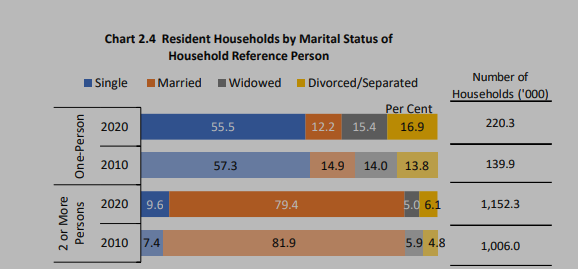

[0.16952641316778871, 0.6855695892192502, 0.06663588479524293, 0.07826811281771828]
MaritalStatus
Married    0.683439
Single     0.175208
Divorced   0.076020
Widowed    0.065334
Name: proportion, dtype: float64


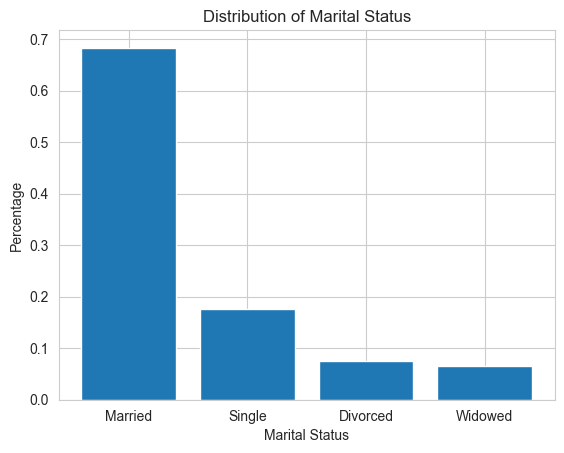

In [973]:
percentage_single = (55.5 * 220.3 + 9.6 * 1152.3) / (220.3 + 1152.3)
percentage_married = (12.2 * 220.3 + 79.4 * 1152.3) / (220.3 + 1152.3)
percentage_widowed = (15.4 * 220.3 + 5 * 1152.3) / (220.3 + 1152.3) #25 above
percentage_divorced = (16.9 * 220.3 + 6.1 * 1152.3) / (220.3 + 1152.3) #25 above

marital_status = ['Single', 'Married', 'Widowed', 'Divorced']
total_percentage = percentage_single + percentage_married + percentage_widowed + percentage_divorced
normalized_percentages = [percentage_single / total_percentage,
                           percentage_married / total_percentage,
                           percentage_widowed / total_percentage,
                           percentage_divorced / total_percentage]
print(normalized_percentages)

bank_df_train['MaritalStatus'] = np.random.choice(['Single', 'Married', 'Widowed', 'Divorced'],
                                                   size=len(bank_df_train), p=normalized_percentages)


young_divorced_widowed_indices = bank_df_train[(bank_df_train['Age'] < 25) & (bank_df_train['MaritalStatus'].isin(['Widowed', 'Divorced']))].index
bank_df_train.loc[young_divorced_widowed_indices, 'MaritalStatus'] = 'Single'


# print(bank_df_train[['Age', 'MaritalStatus']].head(20))
marital_status_distribution = bank_df_train['MaritalStatus'].value_counts(normalize=True)
print(marital_status_distribution)

arital_status_distribution = bank_df_train['MaritalStatus'].value_counts(normalize=True)
plt.bar(marital_status_distribution.index, marital_status_distribution.values)
plt.xlabel('Marital Status')
plt.ylabel('Percentage')
plt.title('Distribution of Marital Status')
plt.show()

In [974]:
# education_marital = pd.read_csv("./data/education_marital.csv")

# marital_status = education_marital['Marital_Status'].unique()

# marital, counts = np.unique(marital_status, return_counts=True)
# value_to_index = {value: i for i, value in enumerate(marital)}
# numerical_data = [value_to_index[value] for value in marital_status]

# kde = gaussian_kde(numerical_data)

# x_values = np.unique(numerical_data)
# pdf_values = kde(x_values)

# pmf = pdf_values / np.sum(pdf_values)

# resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)
# resampled_indices_test = np.random.choice(x_values, size=n_test, p=pmf)

# resampled_values = [marital[index] for index in resampled_indices]
# resampled_values_test = [marital[index] for index in resampled_indices_test]

# bank_df_train['MaritalStatus'] = resampled_values
# bank_df_test['MaritalStatus'] = resampled_values_test

# bank_df_train['MaritalStatus'].replace({'Unknown': 'Divorced'}, inplace=True)
# bank_df_test['MaritalStatus'].replace({'Unknown': 'Divorced'}, inplace=True)

# print(bank_df_train['MaritalStatus'].head(20))

### 23.Housing Status
Reflects stability and long-term commitment, influencing churn. 

In [975]:
housing = pd.read_csv("./data/housing.csv")

housing_status = housing['House_Ownership'].unique()

house, counts = np.unique(housing_status, return_counts=True)
value_to_index = {value: i for i, value in enumerate(house)}
numerical_data = [value_to_index[value] for value in housing_status]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)

pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)
resampled_indices_test = np.random.choice(x_values, size=n_test, p=pmf)

resampled_values = [house[index] for index in resampled_indices]
resampled_values_test = [house[index] for index in resampled_indices_test]

bank_df_train['HousingStatus'] = resampled_values
bank_df_test['HousingStatus'] = resampled_values_test


print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0           1  Okwudilichukwu          668    France   Male   33       6   
1   1           2   Okwudiliolisa          627    France   Male   33       1   
2   2           3           Hsueh          678    France   Male   40      19   
3   3           4             Kao          581    France   Male   34       3   
4   4           5       Chiemenam          716     Spain   Male   33       9   

        Balance  NumOfProducts  ...  ChurnDate  MonthsInactive  \
0 133877.387693              2  ...        NaT             NaN   
1 124654.362135              2  ...        NaT             NaN   
2 152137.330246              2  ...        NaT             NaN   
3 148882.540000              1  ...        NaT             NaN   
4 118487.514477              2  ...        NaT             NaN   

   TransactionFreq  TransactionAmt ServiceSupportFrequency       NPS  \
0               44     1451.211025                

### 24.Number of Dependents
Impacts financial priorities and risk tolerance, affecting churn.

In [976]:
dependents_df = pd.read_csv('./data/education+dependents+maritalstatus/BankChurners.csv')

kde = gaussian_kde(dependents_df['Dependent_count'])

bank_df_train['Dependents'] = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
bank_df_train['Dependents'] = np.round(bank_df_train['Dependents']).astype(int)
bank_df_test['Dependents'] = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)
bank_df_test['Dependents'] = np.round(bank_df_test['Dependents']).astype(int)

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0           1  Okwudilichukwu          668    France   Male   33       6   
1   1           2   Okwudiliolisa          627    France   Male   33       1   
2   2           3           Hsueh          678    France   Male   40      19   
3   3           4             Kao          581    France   Male   34       3   
4   4           5       Chiemenam          716     Spain   Male   33       9   

        Balance  NumOfProducts  ...  MonthsInactive  TransactionFreq  \
0 133877.387693              2  ...             NaN               44   
1 124654.362135              2  ...             NaN                7   
2 152137.330246              2  ...             NaN                5   
3 148882.540000              1  ...             NaN               58   
4 118487.514477              2  ...             NaN                7   

   TransactionAmt  ServiceSupportFrequency       NPS  Education  \
0     1451.211025  

### 25.Marketing Offers Accepted
Indicates responsiveness to incentives, affecting churn. Range 0-1, (percentage of marketing offers they accept, e.g.5 offer, 4 accepted, the value of the column 0.8)

In [977]:
marketing_df = pd.read_csv('./data/marketing offers/marketing_campaign.csv', sep=';')


marketing_df["MarketingOffersAcceptance"] = (marketing_df['AcceptedCmp1'] + marketing_df['AcceptedCmp2'] + marketing_df['AcceptedCmp3'] + marketing_df['AcceptedCmp4'] + marketing_df['AcceptedCmp5']) / 5
# print(marketing_df.head())

kde = gaussian_kde(marketing_df['MarketingOffersAcceptance'])

bank_df_train['MarketingOffersAcceptance'] = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
bank_df_test['MarketingOffersAcceptance'] = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0           1  Okwudilichukwu          668    France   Male   33       6   
1   1           2   Okwudiliolisa          627    France   Male   33       1   
2   2           3           Hsueh          678    France   Male   40      19   
3   3           4             Kao          581    France   Male   34       3   
4   4           5       Chiemenam          716     Spain   Male   33       9   

        Balance  NumOfProducts  ...  TransactionFreq  TransactionAmt  \
0 133877.387693              2  ...               44     1451.211025   
1 124654.362135              2  ...                7     1197.820663   
2 152137.330246              2  ...                5     1975.873397   
3 148882.540000              1  ...               58     1159.449547   
4 118487.514477              2  ...                7     1201.936091   

   ServiceSupportFrequency       NPS  Education  EmploymentStatus  \
0                

### 26.Channel Used for Transactions
Reflects preferred banking channels and engagement level. 
faker

In [978]:
transaction_channel_df = pd.read_csv('./data/main_payment_method/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# print(transaction_channel_df.head())
methods = transaction_channel_df['PaymentMethod'].unique().tolist()
# print(methods)
faked_data = [random.choice(methods) for _ in range(len(bank_df_train))]
faked_data_2 = [random.choice(methods) for _ in range(len(bank_df_test))]

bank_df_train['PaymentMethod'] = faked_data
bank_df_test['PaymentMethod'] = faked_data_2

bank_df_train['PaymentMethod'].replace({'Bank transfer (automatic)': 'Intrabank transfer (GXS Savings Account only)'}, inplace=True)
bank_df_train['PaymentMethod'].replace({'Electronic check': 'PayNow'}, inplace=True)
bank_df_train['PaymentMethod'].replace({'Credit card (automatic)': 'Debit card'}, inplace=True)
bank_df_train['PaymentMethod'].replace({'Mailed check': 'FAST'}, inplace=True)

bank_df_test['PaymentMethod'].replace({'Bank transfer (automatic)': 'Intrabank transfer (GXS Savings Account only)'}, inplace=True)
bank_df_test['PaymentMethod'].replace({'Electronic check': 'PayNow'}, inplace=True)
bank_df_test['PaymentMethod'].replace({'Credit card (automatic)': 'Debit card'}, inplace=True)
bank_df_test['PaymentMethod'].replace({'Mailed check': 'FAST'}, inplace=True)

print(bank_df_train['PaymentMethod'].head(10))

0                                             FAST
1                                       Debit card
2                                       Debit card
3    Intrabank transfer (GXS Savings Account only)
4                                       Debit card
5                                       Debit card
6    Intrabank transfer (GXS Savings Account only)
7                                             FAST
8                                             FAST
9                                       Debit card
Name: PaymentMethod, dtype: object


### 27.Customer Satisfaction Surveys
Provides direct feedback on satisfaction levels, predicting churn. 

In [979]:
cust_satisfaction_df = pd.read_csv('./data/satisfaction score/Customer-Churn-Records.csv')

kde = gaussian_kde(cust_satisfaction_df['Satisfaction Score'])

fake_data = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
fake_data = np.minimum(fake_data.flatten(), 5)
fake_data = np.round(fake_data).astype(int)

fake_data_2 = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)
fake_data_2 = np.minimum(fake_data_2.flatten(), 5)
fake_data_2 = np.round(fake_data_2).astype(int)

bank_df_train['CustomerSatisfaction'] = fake_data
bank_df_test['CustomerSatisfaction'] = fake_data_2
# print(len(bank_df_test))
# print(len(fake_data_2))

print(bank_df_train['CustomerSatisfaction'].head(10))

0    4
1    2
2    1
3    2
4    4
5    3
6    2
7    2
8    4
9    3
Name: CustomerSatisfaction, dtype: int32


### 28.Feature Satisfaction
Scale on 1 to 5


In [980]:
feature_df = pd.read_csv('./data/feature_and_support_satisfaction/Customer-survey-data.csv')
feature_df = feature_df.dropna()
kde = gaussian_kde(feature_df['How satisfied were you with your overall delivery experience at Ali?                    1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied'])
bank_df_train['FeatureSatisfaction'] = kde.resample(len(bank_df_train)).flatten().astype(int)
bank_df_test['FeatureSatisfaction'] = kde.resample(len(bank_df_test)).flatten().astype(int)

print(bank_df_train['FeatureSatisfaction'].head())

0    2
1    2
2    0
3    1
4    1
Name: FeatureSatisfaction, dtype: int32


### 29.Support Satisfaction
Scale on 1 to 5


In [981]:
feature_df = pd.read_csv('./data/feature_and_support_satisfaction/Customer-survey-data.csv')
feature_df = feature_df.dropna()
kde = gaussian_kde(feature_df['How satisfied were you with the speed of delivery at Alis?                                1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied'])
bank_df_train['SupportSatisfaction'] = kde.resample(len(bank_df_train)).flatten().astype(int)
bank_df_test['SupportSatisfaction'] = kde.resample(len(bank_df_test)).flatten().astype(int)

print(bank_df_train['SupportSatisfaction'].head())

0    2
1    5
2    1
3    5
4    4
Name: SupportSatisfaction, dtype: int32


### 30. Feature support frequency

Higher calls might indicate issues and dissatisfaction, affecting churn. Past year. Past month 


In [982]:
support_freq = pd.read_csv("./data/support_frequency.csv")

kde = gaussian_kde(support_freq['no_of_cases'])
bank_df_train['FeatureSupportFrequency'] = abs(kde.resample(n_train).flatten()/12).astype(int)
bank_df_test['FeatureSupportFrequency'] = abs(kde.resample(n_test).flatten()/12).astype(int)
print(bank_df_train.head())


   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0           1  Okwudilichukwu          668    France   Male   33       6   
1   1           2   Okwudiliolisa          627    France   Male   33       1   
2   2           3           Hsueh          678    France   Male   40      19   
3   3           4             Kao          581    France   Male   34       3   
4   4           5       Chiemenam          716     Spain   Male   33       9   

        Balance  NumOfProducts  ...  EmploymentStatus  MaritalStatus  \
0 133877.387693              2  ...          Fulltime        Married   
1 124654.362135              2  ...          Parttime       Divorced   
2 152137.330246              2  ...          Fulltime        Married   
3 148882.540000              1  ...          Parttime        Married   
4 118487.514477              2  ...          Fulltime        Married   

   HousingStatus  Dependents MarketingOffersAcceptance  \
0          owned           2

### 31.Relationship Count
Reflects the breadth of the customer's relationship with the bank.
Shld be correlated to 6: No. of products   

0   27706.570000
1   13881.040000
2   15303.800000
3    3867.580000
4   22632.570000
5    4012.940000
6    6643.510000
7   12826.340000
8   20147.370000
9    9705.540000
Name: LoanAmt, dtype: float64
30000.0
3000.0


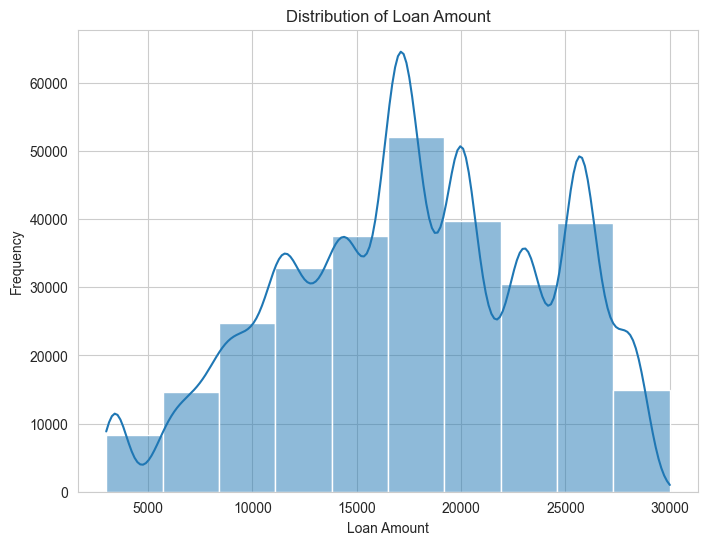

In [983]:
import seaborn as sns
relationship_count = pd.read_csv('./data/loan/credit_train.csv')
relationship_count['Current Loan Amount'].fillna(0, inplace=True) 
relationship_count = relationship_count[relationship_count['Current Loan Amount'] <= 200000]

if np.any(np.isinf(relationship_count['Current Loan Amount'])):
    # Handle infinite values, such as replacing them with a large finite value
    relationship_count['Current Loan Amount'].replace([np.inf, -np.inf], np.finfo(np.float64).max, inplace=True)


median_loan_amount = relationship_count['Current Loan Amount'].median()
below_median = relationship_count[relationship_count['Current Loan Amount'] < median_loan_amount]
above_median = relationship_count[relationship_count['Current Loan Amount'] >= median_loan_amount]

# print(above_median)
kde_upper = gaussian_kde(above_median['Current Loan Amount'])
kde_lower = gaussian_kde(below_median['Current Loan Amount'])

bank_df_train['LoanAmt'] = np.where(bank_df_train['CustomerSatisfaction'] >= 4, abs(kde_upper.resample(n_train).flatten()/12).astype(int) , abs(kde_lower.resample(n_train).flatten()/12).astype(int))
bank_df_test['LoanAmt'] = np.where(bank_df_test['CustomerSatisfaction'] >= 4, abs(kde_upper.resample(n_test).flatten()/12).astype(int) , abs(kde_lower.resample(n_test).flatten()/12).astype(int))

min_value = bank_df_train['LoanAmt'].min()
max_value = bank_df_train['LoanAmt'].max()
min_value_2 = bank_df_test['LoanAmt'].min()
max_value_2 = bank_df_test['LoanAmt'].max()
new_min_value = 3000
new_max_value = 30000

def scale_values(value):
    scaled_value = new_min_value + ((value - min_value) / (max_value - min_value)) * (new_max_value - new_min_value)
    return scaled_value

def scale_values_2(value):
    scaled_value = new_min_value + ((value - min_value_2) / (max_value_2 - min_value_2)) * (new_max_value - new_min_value)
    return scaled_value

bank_df_train['LoanAmt'] = bank_df_train['LoanAmt'].apply(scale_values)
bank_df_test['LoanAmt'] = bank_df_test['LoanAmt'].apply(scale_values_2)

bank_df_train['LoanAmt'] = bank_df_train['LoanAmt'].round(2)
# kde = gaussian_kde(relationship_count['Current Loan Amount'])
# bank_df_train['RelationshipCount'] = abs(kde.resample(n_train).flatten()/12).astype(int)

print(bank_df_train['LoanAmt'].head(10))
print(bank_df_train['LoanAmt'].max())
print(bank_df_train['LoanAmt'].min())

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
sns.histplot(bank_df_train['LoanAmt'], kde=True, bins=10)  # Adjust the number of bins as needed
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Amount')
plt.show()

### 32. Income Source
Indicates financial stability and potential churn risk. 

In [984]:
# income_source_df = pd.read_csv('./data/income source/adult.csv')

# # print(transaction_channel_df.head())
# income_sourcs = income_source_df['workclass'].unique().tolist()
# income_sourcs.remove('?')
# print(income_sourcs)
# faked_data = [random.choice(income_sourcs) for _ in range(len(bank_df_train))]
# faked_data_2 = [random.choice(income_sourcs) for _ in range(len(bank_df_test))]

# bank_df_train['IncomeSource'] = faked_data
# bank_df_test['IncomeSource'] = faked_data_2

def choose_value(row):
    if row['EmploymentStatus'] == 'Fulltime' or row['EmploymentStatus'] == 'Parttime':
        return np.random.choice(['Employment', 'Investment'])
    elif row['EmploymentStatus'] == 'Retired':
        return np.random.choice(['Retirement', 'Rental', 'Investment'])
    elif row['EmploymentStatus'] == 'Student':
        return np.random.choice(['Allowance', 'Employment'])
    elif row['EmploymentStatus'] == 'Self-employed':
        return 'Self-employment'
    elif row['EmploymentStatus'] == 'Unemployed':
        return np.random.choice(['Rental', 'Investment', 'Allowance'])
    
bank_df_train['IncomeSource'] = bank_df_train.apply(choose_value, axis=1)
print(bank_df_train[['EmploymentStatus', 'IncomeSource']].head(10))

  EmploymentStatus IncomeSource
0         Fulltime   Employment
1         Parttime   Employment
2         Fulltime   Employment
3         Parttime   Investment
4         Fulltime   Investment
5         Parttime   Investment
6         Parttime   Investment
7          Student   Employment
8         Fulltime   Employment
9          Retired   Retirement


### 33. Credit Utilization
Reflects financial health and potential churn risk for credit customers.

In [985]:
credit_df = pd.read_csv('./data/credit utilization/BankChurners.csv')

kde = gaussian_kde(credit_df['Avg_Utilization_Ratio'])

fake_data = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
fake_data = np.minimum(fake_data.flatten(), 1)
# fake_data = np.round(fake_data).astype(int)
fake_data_2 = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)
fake_data_2 = np.minimum(fake_data_2.flatten(), 1)

bank_df_train['CreditUtilization'] = fake_data
bank_df_test['CreditUtilization'] = fake_data_2

print(bank_df_train.head())

   id  CustomerId         Surname  CreditScore Geography Gender  Age  Tenure  \
0   0           1  Okwudilichukwu          668    France   Male   33       6   
1   1           2   Okwudiliolisa          627    France   Male   33       1   
2   2           3           Hsueh          678    France   Male   40      19   
3   3           4             Kao          581    France   Male   34       3   
4   4           5       Chiemenam          716     Spain   Male   33       9   

        Balance  NumOfProducts  ...  Dependents  MarketingOffersAcceptance  \
0 133877.387693              2  ...           2                   0.000000   
1 124654.362135              2  ...           4                   0.000000   
2 152137.330246              2  ...           3                   0.012210   
3 148882.540000              1  ...           2                   0.183346   
4 118487.514477              2  ...           1                   0.000000   

                                   PaymentMethod  

### 34. Response to Previous Retention Efforts
Records success or failure of previous retention efforts, guiding future strategies. % 0-1. Using a beta distribution to model this. 

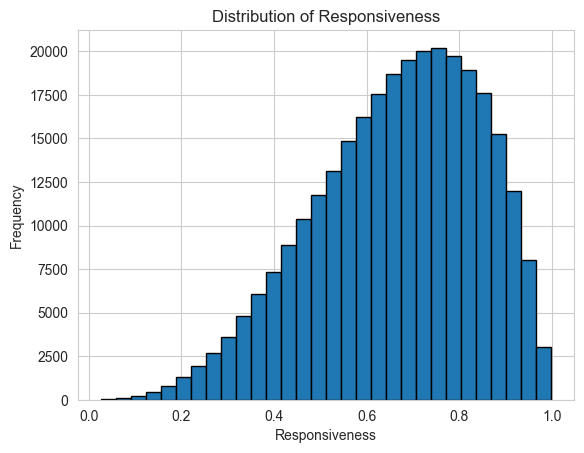

In [986]:
alpha = 4
beta = 2

responsiveness_values = np.random.beta(alpha, beta, size=n_train)

bank_df_train['Retention'] = responsiveness_values

plt.hist(bank_df_train['Retention'], bins=30, edgecolor='black')
plt.xlabel('Responsiveness')
plt.ylabel('Frequency')
plt.title('Distribution of Responsiveness')
plt.show()

In [987]:
# retention_df = pd.read_csv('./data/retention/HR_comma_sep.csv')

# kde = gaussian_kde(retention_df['promotion_last_5years'])

# fake_data = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
# fake_data = np.minimum(fake_data.flatten(), 1)

# fake_data_2 = np.maximum(kde.resample(len(bank_df_test)).flatten(), 0)
# fake_data_2 = np.minimum(fake_data_2.flatten(), 1)


# bank_df_train['Retention'] = fake_data
# bank_df_test['Retention'] = fake_data_2

# print(bank_df_train['Retention'].head(20))

# filtered_retention_rate = bank_df_train[bank_df_train['Retention'] < 0.2]['Retention']


# sns.kdeplot(filtered_retention_rate, shade=True)
# plt.xlabel('Retention Rate')
# plt.ylabel('Density')
# plt.title('Kernel Density Estimation of Retention Rate (<0.2)')
# plt.show()

### 35. Change in behavior before n after
Average of percentage of increase/decrease (ranging from 0 - infinity, but most of the times it will be ard 0-2)

In [988]:
bank_df_train['ChangeInBehaviourMkt'] = np.random.normal(1, 0.25, len(bank_df_train))
bank_df_test['ChangeInBehaviourMkt']= np.random.normal(1, 0.25, len(bank_df_test))
# test = np.random.normal(1, 0.25, len(bank_df_train))
# # print(test)
# bank_df_train['ChangeInBehaviourMkt'] = test.astype(float)

print(bank_df_train['ChangeInBehaviourMkt'].head(10))

0   1.533396
1   1.296535
2   0.850710
3   1.185207
4   1.451284
5   0.813367
6   0.809967
7   0.479508
8   1.026582
9   1.210018
Name: ChangeInBehaviourMkt, dtype: float64


### 36. Change in behavior before n after for Support

In [989]:
bank_df_train['ChangeInBehaviourCust'] = np.random.normal(1, 0.25, len(bank_df_train))
bank_df_test['ChangeInBehaviourCust']= np.random.normal(1, 0.25, len(bank_df_test))

print(bank_df_train['ChangeInBehaviourCust'].head())

0   0.933006
1   0.819056
2   1.308488
3   0.814240
4   1.063163
Name: ChangeInBehaviourCust, dtype: float64


### 37. Previous Lifecycle status 

In [990]:
life_cycles = ['Active', 'Dormant', 'Reactivated'] #everything but churned

# bank_df_train['PrevLifecycle'] = bank_df_train.apply(lambda row: np.random.choice(life_cycles) if row['Tenure'] > 1 else ('Churned' if row['Exited'] == 1 else np.nan), axis=1)
# bank_df_test['PrevLifecycle'] = np.where(bank_df_test['Tenure'] > 1,
#                                           np.random.choice(life_cycles, size=len(bank_df_test)),
#                                           np.nan)

bank_df_train['PrevLifecycle'] = bank_df_train.apply(
    lambda row: 'Churned' if row['Exited'] == 1 else np.random.choice(life_cycles) if row['Tenure'] > 1 else np.nan,
    axis=1
)

# bank_df_test['PrevLifecycle'] = np.where(
#     bank_df_test['Exited'] == 1,
#     'Churned',
#     np.where(
#         bank_df_test['Tenure'] > 1,
#         np.random.choice(life_cycles, size=len(bank_df_test)),
#         np.nan
#     )
# )

print(bank_df_train[['ChurnDate', 'Tenure', 'PrevLifecycle']].head(50))
# print(bank_df_test[['Tenure', 'PrevLifecycle']].head(20))

    ChurnDate  Tenure PrevLifecycle
0         NaT       6        Active
1         NaT       1           NaN
2         NaT      19        Active
3         NaT       3       Dormant
4         NaT       9       Dormant
5  2023-06-17       8       Churned
6         NaT      14   Reactivated
7         NaT       1           NaN
8         NaT       7   Reactivated
9         NaT       7        Active
10        NaT      11   Reactivated
11        NaT       5        Active
12        NaT      17   Reactivated
13        NaT       9       Dormant
14        NaT      12        Active
15        NaT       9       Dormant
16        NaT      12       Dormant
17        NaT       8   Reactivated
18 2024-01-19      15       Churned
19 2023-09-06       1       Churned
20        NaT      16        Active
21        NaT      15   Reactivated
22        NaT      16        Active
23 2024-03-14      17       Churned
24        NaT      10   Reactivated
25 2024-01-26      16       Churned
26        NaT       5   Reac

### 38. Current Lifecycle status 

In [991]:
prev_active = ['Active', 'Dormant'] #excluding churn, also same for reactivated
prev_dormant = ['Dormant', 'Reactivated'] #excluding churn

# bank_df_train['CurrLifecycle'] = bank_df_train.apply(lambda row: 'Churned' if row['PrevLifecycle'] == 'Churned' else \
#                                                     np.random.choice(prev_active) if (row['PrevLifecycle'] == 'Active' or row['PrevLifecycle'] == 'Reactivated') else \
#                                                     np.random.choice(prev_dormant) if row['PrevLifecycle'] == 'Dormant' else \
#                                                     np.nan, axis=1)
bank_df_train['CurrLifecycle'] = bank_df_train.apply(lambda row: 'Churned' if row['PrevLifecycle'] == 'Churned' else \
                                                     'Reactivated' if (row['PrevLifecycle'] == 'Dormant' and row['TransactionFreq'] > 0) else \
                                                     'Dormant' if row['TransactionFreq'] == 0 else \
                                                     'Active', axis=1)

print(bank_df_train[['PrevLifecycle', 'CurrLifecycle']].head(10))


  PrevLifecycle CurrLifecycle
0        Active        Active
1           NaN        Active
2        Active        Active
3       Dormant   Reactivated
4       Dormant   Reactivated
5       Churned       Churned
6   Reactivated        Active
7           NaN        Active
8   Reactivated        Active
9        Active        Active


### 39. Customer Happiness Status 
1 == happy, 0 == unhappy

Customer satisfaction survey score 

Relationship Count 

Response to previous retention efforts (no more yay)

if we want the top 15.9%


In [992]:
happiness_benchmark = 50

# bank_df_train['Happiness'] = bank_df_train.apply(lambda row: 1 if row['CustomerSatisfaction'] + \
#                                                                   row['FeatureSatisfaction'] + \
#                                                                   row['SupportSatisfaction'] + \
#                                                                   row['NPS'] + \
#                                                                   row['Tenure'] >= happiness_benchmark else \
#                                                                   0, axis=1)


# need to delete Custpercentile, RsPercentile and ResponsePercentile later
bank_df_train['CustPercentile'] = bank_df_train['CustomerSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_train['CustomerSatisfaction'], x))
bank_df_train['RsPercentile'] = bank_df_train['LoanAmt'].apply(lambda x: stats.percentileofscore(bank_df_train['CustomerSatisfaction'], x))

bank_df_test['CustPercentile'] = bank_df_test['CustomerSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_test['CustomerSatisfaction'], x))
bank_df_test['RsPercentile'] = bank_df_test['LoanAmt'].apply(lambda x: stats.percentileofscore(bank_df_test['CustomerSatisfaction'], x))

# print(bank_df_train['CustPercentile'].head(10))
bank_df_train['Happiness'] = bank_df_train.apply(lambda row: 1 if (row['CustPercentile'] > happiness_benchmark and \
                                                                   row['RsPercentile'] > happiness_benchmark ) else 0, axis=1)
bank_df_train.drop(columns=['CustPercentile', 'RsPercentile'], inplace=True)

bank_df_test['Happiness'] = bank_df_test.apply(lambda row: 1 if (row['CustPercentile'] > happiness_benchmark and \
                                                                   row['RsPercentile'] > happiness_benchmark ) else 0, axis=1)
bank_df_test.drop(columns=['CustPercentile', 'RsPercentile'], inplace=True)

# print(bank_df_train['Happiness'].head(10))
# print("percentage happy =", (bank_df_train['Happiness'] == 1).mean() * 100)
print(bank_df_test['Happiness'].head(10))
print("percentage happy =", (bank_df_test['Happiness'] == 1).mean() * 100)

0    1
1    1
2    0
3    0
4    1
5    0
6    1
7    0
8    1
9    0
Name: Happiness, dtype: int64
percentage happy = 40.07525699171992


### 40.Price Sensitivity %
26. marketing offers accepted %
35. change in behaviour %

Mkting Offers Accepted
Change in behavior before n after for mkting offer 


In [993]:
# MarketingOffersAcceptance_df = bank_df_train['MarketingOffersAcceptance'].apply(lambda x: stats.percentileofscore(bank_df_train['MarketingOffersAcceptance'], x))
# ChangeInBehaviourMkt_df = bank_df_train['ChangeInBehaviourMkt'].apply(lambda x: stats.percentileofscore(bank_df_train['ChangeInBehaviourMkt'], x))

# MarketingOffersAcceptance_df_2 = bank_df_test['MarketingOffersAcceptance'].apply(lambda x: stats.percentileofscore(bank_df_test['MarketingOffersAcceptance'], x))
# ChangeInBehaviourMkt_df_2 = bank_df_test['ChangeInBehaviourMkt'].apply(lambda x: stats.percentileofscore(bank_df_test['ChangeInBehaviourMkt'], x))
# # print(MarketingOffersAcceptance_df.head())
# # print(ChangeInBehaviourMkt_df.head())
# bank_df_train['PriceSensitivity'] = (MarketingOffersAcceptance_df + ChangeInBehaviourMkt_df) / 2
# bank_df_test['PriceSensitivity'] = (MarketingOffersAcceptance_df_2 + ChangeInBehaviourMkt_df_2) / 2

# print(bank_df_train['PriceSensitivity'].head(20))

In [994]:
bank_df_train['Savings Savant'] = ((bank_df_train['MarketingOffersAcceptance'].rank(pct=True)*100).astype(int)+(bank_df_train['ChangeInBehaviourMkt'].rank(pct=True)*100).astype(int))/2
bank_df_test['Savings Savant'] = ((bank_df_test['MarketingOffersAcceptance'].rank(pct=True)*100).astype(int)+(bank_df_test['ChangeInBehaviourMkt'].rank(pct=True)*100).astype(int))/2

### 41.Feature Driven % 
28. Customer satisfaction survey 0-5
6. num products 1-4
29. Feature Satisfaction 0-5

Number of products last 1 year
Feature Satisfaction Column (0 to 1)
Feature Support freq


In [995]:
# print(bank_df_train['NumOfProducts'].max())
# print(bank_df_train['NumOfProducts'].min())

# feature_driven = bank_df_train['CustomerSatisfaction'] + bank_df_train['NumOfProducts'] + bank_df_train['FeatureSatisfaction']
# percentiles = np.percentile(feature_driven, [0, 25, 50, 75, 100]) 

# def assign_percentile(metric):
#     if metric <= percentiles[1]:
#         return ((metric / percentiles[1]) * 25)
#     elif metric <= percentiles[2]:
#         return (25 + ((metric - percentiles[1]) / (percentiles[2] - percentiles[1])) * 25)
#     elif metric <= percentiles[3]:
#         return (50 + ((metric - percentiles[2]) / (percentiles[3] - percentiles[2])) * 25)
#     else:
#         return (75 + ((metric - percentiles[3]) / (percentiles[4] - percentiles[3])) * 25)
        
# bank_df_train['FeatureSensitivity'] = feature_driven.apply(assign_percentile)
# bank_df_train['FeatureSensitivity'] = bank_df_train['FeatureSensitivity'].replace(np.NaN, 0, regex=True)

# CustomerSatisfaction_df = bank_df_train['CustomerSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_train['CustomerSatisfaction'], x))
# NumOfProducts_df = bank_df_train['NumOfProducts'].apply(lambda x: stats.percentileofscore(bank_df_train['NumOfProducts'], x))
# FeatureSatisfaction_df = bank_df_train['FeatureSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_train['FeatureSatisfaction'], x))
# FeatureSupportFrequency_df = bank_df_train['FeatureSupportFrequency'].apply(lambda x: stats.percentileofscore(bank_df_train['FeatureSatisfaction'], x))

# CustomerSatisfaction_df_2 = bank_df_test['CustomerSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_test['CustomerSatisfaction'], x))
# NumOfProducts_df_2 = bank_df_test['NumOfProducts'].apply(lambda x: stats.percentileofscore(bank_df_test['NumOfProducts'], x))
# FeatureSatisfaction_df_2 = bank_df_test['FeatureSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_test['FeatureSatisfaction'], x))
# FeatureSupportFrequency_df_2 = bank_df_test['FeatureSupportFrequency'].apply(lambda x: stats.percentileofscore(bank_df_test['FeatureSatisfaction'], x))

# bank_df_train['FeatureSensitivity'] = (CustomerSatisfaction_df + NumOfProducts_df + FeatureSatisfaction_df + FeatureSupportFrequency_df) / 4
# bank_df_test['FeatureSensitivity'] = (CustomerSatisfaction_df_2 + NumOfProducts_df_2 + FeatureSatisfaction_df_2 + FeatureSupportFrequency_df_2) / 4

# print(bank_df_train['FeatureSensitivity'].head(20))

In [996]:
bank_df_train['Digital Dynamos'] = ((bank_df_train['CustomerSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_train['NumOfProducts'].rank(pct=True)*100).astype(int)+(bank_df_train['FeatureSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_train['FeatureSupportFrequency'].rank(pct=True)*100).astype(int))/4
bank_df_test['Digital Dynamos'] = ((bank_df_test['CustomerSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_test['NumOfProducts'].rank(pct=True)*100).astype(int)+(bank_df_test['FeatureSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_test['FeatureSupportFrequency'].rank(pct=True)*100).astype(int))/4


### 42.Service Dependent % 
31. service support freq per month number
39. Customer Happiness Status binary
36. Change in behavior before n after for Support %

CALL Support frequency
Support Satisfaction Column (0 to 1)
Change in behavior before n after support

In [997]:
# print(bank_df_train['ServiceSupportFrequency'])
# CallSupportFrequency_df = bank_df_train['CallSupportFrequency'].apply(lambda x: stats.percentileofscore(bank_df_train['CallSupportFrequency'], x))
# ServiceSupportFrequency_df = bank_df_train['ServiceSupportFrequency'].apply(lambda x: stats.percentileofscore(bank_df_train['ServiceSupportFrequency'], x))
# SupportSatisfaction_df = bank_df_train['SupportSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_train['SupportSatisfaction'], x))
# ChanegInBehaviourCust_df = bank_df_train['ChanegInBehaviourCust'].apply(lambda x: stats.percentileofscore(bank_df_train['ChanegInBehaviourCust'], x))

# ServiceSupportFrequency_df_2 = bank_df_test['ServiceSupportFrequency'].apply(lambda x: stats.percentileofscore(bank_df_test['ServiceSupportFrequency'], x))
# SupportSatisfaction_df_2 = bank_df_test['SupportSatisfaction'].apply(lambda x: stats.percentileofscore(bank_df_test['SupportSatisfaction'], x))
# ChanegInBehaviourCust_df_2 = bank_df_test['ChanegInBehaviourCust'].apply(lambda x: stats.percentileofscore(bank_df_test['ChanegInBehaviourCust'], x))

# bank_df_train['ServiceSensitivity'] = (ServiceSupportFrequency_df + SupportSatisfaction_df + ChanegInBehaviourCust_df) / 3
# bank_df_test['ServiceSensitivity'] = (ServiceSupportFrequency_df_2 + SupportSatisfaction_df_2 + ChanegInBehaviourCust_df_2) / 3

# print(bank_df_train['ServiceSensitivity'].head())

In [998]:
bank_df_train['Trustee Tribe'] = ((bank_df_train['ServiceSupportFrequency'].rank(pct=True)*100).astype(int)+(bank_df_train['SupportSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_train['ChangeInBehaviourCust'].rank(pct=True)*100).astype(int))/3
bank_df_test['Trustee Tribe'] = ((bank_df_test['ServiceSupportFrequency'].rank(pct=True)*100).astype(int)+(bank_df_test['SupportSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_test['ChangeInBehaviourCust'].rank(pct=True)*100).astype(int))/3
print(bank_df_train['Trustee Tribe'].head())

0   32.333333
1   64.666667
2   48.000000
3   45.000000
4   72.666667
Name: Trustee Tribe, dtype: float64


### 43.Customer Personas 

In [999]:
print(bank_df_train[['Savings Savant', 'Digital Dynamos', 'Trustee Tribe']])

       Savings Savant  Digital Dynamos  Trustee Tribe
0           58.500000        48.500000      32.333333
1           53.500000        43.750000      64.666667
2           39.500000        24.500000      48.000000
3           80.000000        40.500000      45.000000
4           57.500000        52.250000      72.666667
...               ...              ...            ...
45221       54.500000        45.250000      37.666667
97560       53.000000        51.500000      93.666667
51170       38.000000        38.250000      56.666667
77844       61.500000        36.750000      67.666667
46445       43.500000        36.500000      62.000000

[295147 rows x 3 columns]


In [1000]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Restore default warning behavior after your code
# warnings.simplefilter(action='default', category=FutureWarning)

persona_df = bank_df_train[['Savings Savant', 'Digital Dynamos', 'Trustee Tribe']]
largest_values = persona_df.max(axis=1)
smallest_values = persona_df.min(axis=1)

sum_values = persona_df.sum(axis=1)
second_largest_values = sum_values - largest_values - smallest_values
first_diff = largest_values - second_largest_values
second_diff = largest_values - smallest_values

def get_columns(row):
    sorted_indices = np.argsort(row)[::-1]  
    largest_index = sorted_indices[0]  
    second_largest_index = sorted_indices[1] 
    smallest_index = sorted_indices[-1] 
    return (persona_df.columns[largest_index], persona_df.columns[second_largest_index], persona_df.columns[smallest_index])

columns_tuple = persona_df.apply(get_columns, axis=1)
bank_df_train[['FirstPersona', 'SecondPersona', 'ThirdPersona']] = pd.DataFrame(columns_tuple.tolist(), index=persona_df.index)
bank_df_train.loc[first_diff > 10, ['SecondPersona', 'ThirdPersona']] = np.nan
bank_df_train.loc[second_diff > 10, ['ThirdPersona']] = np.nan

print(bank_df_train[['FirstPersona', 'SecondPersona', 'ThirdPersona']].head(10))

persona_df_2 = bank_df_test[['Savings Savant', 'Digital Dynamos', 'Trustee Tribe']]
largest_values_2 = persona_df_2.max(axis=1)
smallest_values_2 = persona_df_2.min(axis=1)

sum_values_2 = persona_df_2.sum(axis=1)
second_largest_values_2 = sum_values_2 - largest_values_2 - smallest_values_2
first_diff_2 = largest_values_2 - second_largest_values_2
second_diff_2 = largest_values_2 - smallest_values_2

columns_tuple_2 = persona_df_2.apply(get_columns, axis=1)
bank_df_test[['FirstPersona', 'SecondPersona', 'ThirdPersona']] = pd.DataFrame(columns_tuple_2.tolist()).reset_index(drop=True)

bank_df_test.loc[first_diff_2 > 10, ['SecondPersona', 'ThirdPersona']] = np.nan
bank_df_test.loc[second_diff_2 > 10, ['ThirdPersona']] = np.nan

print(bank_df_test[['FirstPersona', 'SecondPersona', 'ThirdPersona']].head(20))
# print(persona_df_2.head(10))


      FirstPersona    SecondPersona    ThirdPersona
0   Savings Savant  Digital Dynamos             NaN
1    Trustee Tribe              NaN             NaN
2    Trustee Tribe   Savings Savant             NaN
3   Savings Savant              NaN             NaN
4    Trustee Tribe              NaN             NaN
5  Digital Dynamos    Trustee Tribe             NaN
6    Trustee Tribe  Digital Dynamos  Savings Savant
7    Trustee Tribe              NaN             NaN
8  Digital Dynamos              NaN             NaN
9   Savings Savant              NaN             NaN
       FirstPersona    SecondPersona ThirdPersona
0     Trustee Tribe  Digital Dynamos          NaN
1     Trustee Tribe              NaN          NaN
2   Digital Dynamos   Savings Savant          NaN
3    Savings Savant              NaN          NaN
4     Trustee Tribe              NaN          NaN
5    Savings Savant    Trustee Tribe          NaN
6     Trustee Tribe              NaN          NaN
7     Trustee Tribe         

In [1001]:
columns_to_normalize = ['Savings Savant', 'Digital Dynamos', 'Trustee Tribe']

bank_df_train[columns_to_normalize] = bank_df_train[columns_to_normalize].div(bank_df_train[columns_to_normalize].sum(axis=1), axis=0) * 100
# bank_df_train['CustomerPersona'] = bank_df_train[columns_to_normalize].idxmax(axis=1)

bank_df_test[columns_to_normalize] = bank_df_test[columns_to_normalize].div(bank_df_test[columns_to_normalize].sum(axis=1), axis=0) * 100
# bank_df_test['CustomerPersona'] = bank_df_test[columns_to_normalize].idxmax(axis=1)

print(bank_df_train[['Savings Savant', 'Digital Dynamos', 'Trustee Tribe']])

       Savings Savant  Digital Dynamos  Trustee Tribe
0           41.985646        34.808612      23.205742
1           33.041688        27.020072      39.938240
2           35.267857        21.875000      42.857143
3           48.338369        24.471299      27.190332
4           31.521243        28.643216      39.835541
...               ...              ...            ...
45221       39.660400        32.929048      27.410552
97560       26.745164        25.988225      47.266611
51170       28.589342        28.777429      42.633229
77844       37.066801        22.149674      40.783526
46445       30.633803        25.704225      43.661972

[295147 rows x 3 columns]


### 44. Social Influencer

0    0
1    1
2    1
3    1
4    1
5    0
6    1
7    1
8    0
9    1
Name: SocialInfluencer, dtype: int64
percentage social influencer = 52.134360166290016


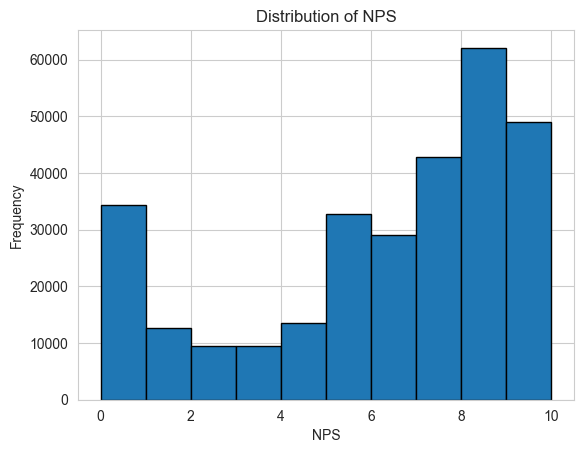

In [1002]:
social_benchmark = 84.1

bank_df_train['SocialInfluencer'] = bank_df_train['NPS'].apply(lambda x: stats.percentileofscore(bank_df_train['NPS'], x))
bank_df_train['SocialInfluencer'] = bank_df_train.apply(lambda row: 1 if (row['SocialInfluencer'] > happiness_benchmark) else 0, axis=1)

bank_df_test['SocialInfluencer'] = bank_df_test['NPS'].apply(lambda x: stats.percentileofscore(bank_df_test['NPS'], x))
bank_df_test['SocialInfluencer'] = bank_df_test.apply(lambda row: 1 if (row['SocialInfluencer'] > happiness_benchmark) else 0, axis=1)

print(bank_df_train['SocialInfluencer'].head(10))
print("percentage social influencer =", (bank_df_train['SocialInfluencer'] == 1).mean() * 100)


plt.hist(bank_df_train['NPS'], bins=10, edgecolor='black')
plt.xlabel('NPS')
plt.ylabel('Frequency')
plt.title('Distribution of NPS')
plt.show()

### 45. Combined Personas column

In [1003]:
# bank_df_train['CombinedPersonas'] = bank_df_train[['FirstPersona', 'SecondPersona', 'ThirdPersona']].apply(lambda row: ', '.join(row.dropna().astype(str)), axis=1)
# bank_df_test['CombinedPersonas'] = bank_df_test[['FirstPersona', 'SecondPersona', 'ThirdPersona']].apply(lambda row: ', '.join(row.dropna().astype(str)), axis=1)
def combine_personas(row):
    if ('Savings Savant' in row.values) and ('Digital Dynamos' in row.values) and ('Trustee Tribe' in row.values):
        return 'Triple Advantage Allies'
    elif ('Savings Savant' in row.values) and ('Digital Dynamos' in row.values):
        return 'Frugal Innovators'
    elif ('Savings Savant' in row.values) and ('Trustee Tribe' in row.values):
        return 'Cost-Conscious Careseekers'
    elif ('Digital Dynamos' in row.values) and ('Trustee Tribe' in row.values):
        return 'Premium Patrons'
    elif 'Savings Savant' in row.values:
        return 'Savings Savant'
    elif 'Digital Dynamos' in row.values:
        return 'Digital Dynamos'
    elif 'Trustee Tribe' in row.values:
        return 'Trustee Tribe'
bank_df_train['CombinedPersonas'] = bank_df_train[['FirstPersona', 'SecondPersona', 'ThirdPersona']].apply(combine_personas, axis=1)
print(bank_df_train['CombinedPersonas'].head(10))

0             Frugal Innovators
1                 Trustee Tribe
2    Cost-Conscious Careseekers
3                Savings Savant
4                 Trustee Tribe
5               Premium Patrons
6       Triple Advantage Allies
7                 Trustee Tribe
8               Digital Dynamos
9                Savings Savant
Name: CombinedPersonas, dtype: object


# Removing useless columns

In [1004]:
# print(bank_df_train.dtypes)
useless_cols = ['id', 'Surname', 'Geography', 'Exited', 'IsActiveMember', 'CreditScore', 'HasCrCard', 'CreditUtilization']
useless_cols_2 = ['id', 'CustomerId', 'Surname', 'Geography', 'IsActiveMember', 'CreditScore', 'HasCrCard', 'CreditUtilization']
# to_one_hot_encode_cols = ['Gender', 'Education', 'Employment Status', 'Marital Status', 'Housing Status', 'PaymentMethod', 'IncomeSource', 'PrevLifecycle', 'CurrLifecycle', 'CustomerPersona']

bank_df_train.drop(columns=useless_cols, inplace=True)
bank_df_test.drop(columns=useless_cols_2, inplace=True)
# bank_df_train = pd.get_dummies(bank_df_train, columns=to_one_hot_encode_cols)



In [1005]:
# reference_date = bank_df_train['ChurnDate'].min()
# bank_df_train['ChurnDate_Numeric'] = (bank_df_train['ChurnDate'] - reference_date).dt.days
# bank_df_train['ChurnDate_Numeric'] = pd.to_numeric(bank_df_train['ChurnDate'])


print(bank_df_train.dtypes)
print(bank_df_train.head(10))
print(bank_df_test[['FirstPersona', 'SecondPersona', 'ThirdPersona', 'Happiness', 'SocialInfluencer']].head(10))

# to get our dates back
# bank_df_train['ChurnDate_Back'] = reference_date + pd.to_timedelta(bank_df_train['ChurnDate_Numeric'], unit='D')

CustomerId                            int64
Gender                               object
Age                                   int32
Tenure                                int32
Balance                             float64
NumOfProducts                         int64
EstimatedSalary                     float64
ChurnDate                    datetime64[ns]
MonthsInactive                      float64
TransactionFreq                       int32
TransactionAmt                      float64
ServiceSupportFrequency               int32
NPS                                 float64
Education                            object
EmploymentStatus                     object
MaritalStatus                        object
HousingStatus                        object
Dependents                            int32
MarketingOffersAcceptance           float64
PaymentMethod                        object
CustomerSatisfaction                  int32
FeatureSatisfaction                   int32
SupportSatisfaction             

In [1006]:
print(bank_df_test.dtypes)
print(bank_df_test.head(10))

Gender                        object
Age                            int32
Tenure                         int64
Balance                      float64
NumOfProducts                  int64
EstimatedSalary              float64
MonthsInactive                 int32
TransactionFreq                int32
TransactionAmt               float64
ServiceSupportFrequency        int32
NPS                          float64
Education                     object
EmploymentStatus              object
HousingStatus                 object
Dependents                     int32
MarketingOffersAcceptance    float64
PaymentMethod                 object
CustomerSatisfaction           int32
FeatureSatisfaction            int32
SupportSatisfaction            int32
FeatureSupportFrequency        int32
LoanAmt                      float64
ChangeInBehaviourMkt         float64
ChangeInBehaviourCust        float64
Happiness                      int64
Savings Savant               float64
Digital Dynamos              float64
T

### One hot encoding Current Lifecycle 

In [1007]:
one_hot_encode_prev = pd.get_dummies(bank_df_train, columns=['PrevLifecycle'],dtype ='int').iloc[:,-4:]
one_hot_encode_curr = pd.get_dummies(bank_df_train, columns=['CurrLifecycle'],dtype ='int').iloc[:,-4:]
bank_df_train = pd.concat([bank_df_train, one_hot_encode_prev, one_hot_encode_curr], axis = 1)

# one_hot_encode2 = pd.get_dummies(bank_df_test, columns=['PrevLifecycle'],dtype ='int').iloc[:,-4:]
# bank_df_test = pd.concat([bank_df_test, one_hot_encode2], axis = 1)

### FOR THE TIME BEING, PUT SOME CURR LIFECYCLE = DORMANT 

In [1008]:
# n = round(bank_df_train.shape[0]*0.25)
# bank_df_train['CurrLifecycle'].iloc[:n] = "Dormant"

# print(bank_df_train['CurrLifecycle'].head)

# EDA


### 1. Correlation matrix

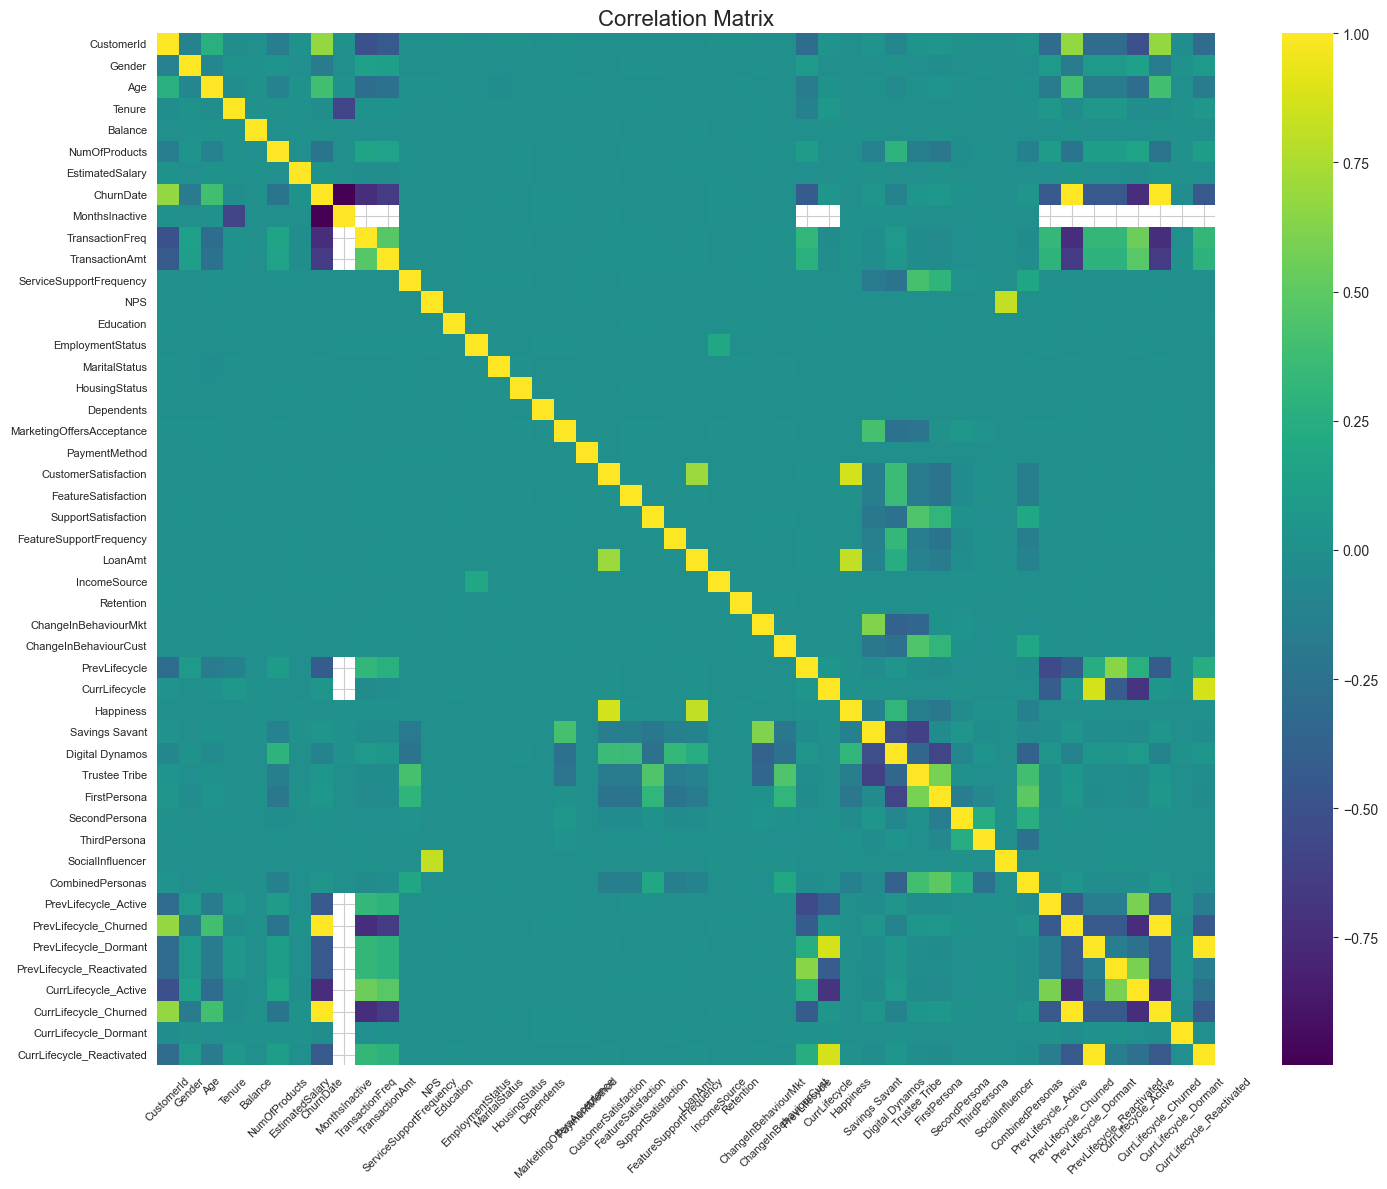

CustomerId and ChurnDate: 0.6786232971710814
CustomerId and PrevLifecycle_Churned: 0.6786256969273174
CustomerId and CurrLifecycle_Churned: 0.6786256969273174
Tenure and MonthsInactive: -0.5993656871756922
ChurnDate and CustomerId: 0.6786232971710814
ChurnDate and MonthsInactive: -0.997848886380136
ChurnDate and TransactionFreq: -0.7378453522737648
ChurnDate and TransactionAmt: -0.6476909900591108
ChurnDate and PrevLifecycle_Churned: 0.9999987976134137
ChurnDate and CurrLifecycle_Active: -0.7466916837588508
ChurnDate and CurrLifecycle_Churned: 0.9999987976134137
MonthsInactive and Tenure: -0.5993656871756922
MonthsInactive and ChurnDate: -0.997848886380136
TransactionFreq and ChurnDate: -0.7378453522737648
TransactionFreq and PrevLifecycle_Churned: -0.7378462394501593
TransactionFreq and CurrLifecycle_Active: 0.5521988755299029
TransactionFreq and CurrLifecycle_Churned: -0.7378462394501593
TransactionAmt and ChurnDate: -0.6476909900591108
TransactionAmt and PrevLifecycle_Churned: -0.64

In [1009]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming bank_df_train is your DataFrame with both numeric and categorical columns

# Create a copy of the DataFrame
encoded_df = bank_df_train.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns using LabelEncoder
for col in encoded_df.select_dtypes(include=['object']):
    encoded_df[col] = label_encoder.fit_transform(encoded_df[col])

# Calculate correlation matrix
corr_matrix = encoded_df.corr()

# Plot the heatmap for all columns without numeric annotations
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='viridis')

# Customize the plot
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Display the plot
plt.tight_layout()
plt.show()

# Identify highly correlated columns
correlated_columns = []
threshold = 0.51   # Adjust as needed

for col in corr_matrix.columns:
    correlated_cols = corr_matrix.index[(corr_matrix[col] > threshold) | (corr_matrix[col] < -threshold)].tolist()
    correlated_cols.remove(col)  # Remove the current column itself
    correlated_columns.extend([(col, corr) for corr in correlated_cols])

# Print highly correlated columns and their correlations
for col, corr in correlated_columns:
    print(f"{col} and {corr}: {corr_matrix.loc[col, corr]}")

In [1010]:
# Identify highly correlated columns with 'Account balance'
target_column = 'Balance'
correlated_with_target = corr_matrix[target_column].drop(target_column).sort_values(ascending=False)

# Print the most highly correlated column and its correlation value
most_correlated_column = correlated_with_target.index[0]
correlation_value = correlated_with_target.iloc[0]
print(f"The column most highly correlated with '{target_column}' is '{most_correlated_column}' with a correlation of {correlation_value:.2f}")


The column most highly correlated with 'Balance' is 'Gender' with a correlation of 0.01


In [1011]:
# Assuming 'column1' and 'column2' are the names of the two specific columns you want to find the correlation for
column1 = 'Balance'
column2 = 'Age'

# Find the correlation value between 'column1' and 'column2'
correlation_value = corr_matrix.loc[column1, column2]

# Print the correlation value
print(f"The correlation value between '{column1}' and '{column2}' is {correlation_value:.2f}")


The correlation value between 'Balance' and 'Age' is 0.00


### 2. LDA

In [1012]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# # Assuming bank_df_train is already defined and contains your data

# # Create a copy of bank_df_train
# test_df = bank_df_train.copy()

# # Separate features and target
# y = test_df['Exited']
# X = test_df.drop(columns=['Exited'])  # Drop 'Exited' column and create X

# # Convert X and y to numpy arrays
# X = np.array(X)
# y = np.array(y)

# # Reshape y to a 1D array if needed
# if y.ndim > 1:
#     y = y.ravel()

# # Initialize LDA model
# lda = LinearDiscriminantAnalysis(n_components=1)  # Set the number of components (dimensions)

# # Fit the model to the data
# lda.fit(X, y)

# # Transform the data
# X_lda = lda.transform(X)

# # Add the transformed data to the DataFrame
# test_df['LDA_Component'] = X_lda

# # Print the DataFrame with LDA component
# print(test_df)


### 3. Try MCA 

In [1013]:
#col_idx = [(i, column_name) for i, column_name in enumerate(bank_df_train.columns)]

In [1014]:
#X_train_1 = bank_df_train.iloc[:, [1] + list(range(14, 17)) + [20, 26]]
#X_train_2 = bank_df_train.iloc[:, 21:38]

In [1015]:
# mca = prince.MCA(n_components=2)
# mca = mca.fit(X_train_1)

In [1016]:
# mca.column_contributions_.head().style.format('{:.0%}')

### 4. FAMD

In [1017]:
# famd = prince.FAMD(n_components=2)
# famd = famd.fit(X_train_2)

# Export to csv

In [1018]:
from sklearn.model_selection import train_test_split
# bank_df_train.to_csv('./data/final/dataset.csv', index=False)
# bank_df_test.to_csv('./data/final/test_data.csv', index=False)

# Assuming your DataFrame is named df and contains your data
# Splitting into train and test sets with a ratio of 2:8
train_df, test_df = train_test_split(bank_df_train, test_size=0.2, random_state=42, stratify=bank_df_train['CurrLifecycle'])

# Print the sizes of the train and test sets
print("Train set size:", len(train_df))
print("Test set size:", len(test_df))

train_df.to_csv('./data/final/train.csv', index=False)
test_df.to_csv('./data/final/test.csv', index=False)

Train set size: 236117
Test set size: 59030


# Model Training

In [1019]:
bank_df_train 
bank_df_test #missing ChurnDate and CurrLifecycle

,Gender,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,MonthsInactive,TransactionFreq,TransactionAmt,ServiceSupportFrequency,...,ChangeInBehaviourMkt,ChangeInBehaviourCust,Happiness,Savings Savant,Digital Dynamos,Trustee Tribe,FirstPersona,SecondPersona,ThirdPersona,SocialInfluencer
0,Female,23,2,0.000000,2,160976.750000,0,56,1044.312090,2,...,0.425019,1.276703,1,8.102633,45.172181,46.725186,Trustee Tribe,Digital Dynamos,NaN,1
1,Female,46,2,0.000000,1,72549.270000,0,4,904.421905,13,...,0.812920,1.544396,1,12.886328,38.501833,48.611839,Trustee Tribe,NaN,NaN,0
2,Female,34,7,0.000000,2,138882.090000,0,49,837.012985,8,...,0.863136,0.781760,0,37.800687,40.206186,21.993127,Digital Dynamos,Savings Savant,NaN,1
3,Male,36,8,0.000000,1,113931.570000,0,35,1175.708013,0,...,1.146569,0.767405,0,44.009780,32.518337,23.471883,Savings Savant,NaN,NaN,1
4,Male,38,10,121263.620000,1,139431.000000,0,35,2334.702405,5,...,0.867120,1.399380,1,21.305483,33.368146,45.326371,Trustee Tribe,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,Male,29,7,116099.820000,1,148087.620000,0,37,254.688057,0,...,0.630038,0.928188,0,23.918575,44.529262,31.552163,Digital Dynamos,NaN,NaN,0
110019,Female,36,4,178032.530000,1,42181.680000,0,43,1102.552136,57,...,1.277633,1.009936,0,42.101137,22.932183,34.966680,Savings Savant,NaN,NaN,1
110020,Male,31,2,0.000000,2,16287.380000,1,9,837.489362,0,...,0.944995,1.265808,0,31.961259,34.140436,33.898305,Digital Dynamos,Trustee Tribe,Savings Savant,1
110021,Female,32,3,0.000000,1,158816.580000,0,31,8093.976201,3,...,1.627315,0.920320,1,49.242028,19.602718,31.155254,Savings Savant,NaN,NaN,0
